In [1]:
%load_ext autoreload

# Gaussian Mixture Model for IPOC data

In [13]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..')))

from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import GMM

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [5]:
for e in db.get_all_collections():
    if 'I_STRENGTH' in e:
        print(e)

df = db.query("MKI.UA23.IPOC.AB1:T_LENGTH|MKI.UA23.IPOC.AB1:I_STRENGTH")
print('------')
print(df.columns[0])
print(df.values[0])
#print(df[df.columns[0]]) # returns a Series with index
print(df[df.columns[0]].values) # returns a Series

# display(df, df.shape)
df.describe()

MKI.UA87.IPOC.BB2:I_STRENGTH
MKI.UA87.IPOC.AB2:I_STRENGTH
MKI.UA23.IPOC.CB1:I_STRENGTH
MKI.UA23.IPOC.BB1:I_STRENGTH
MKI.UA87.IPOC.CB2:I_STRENGTH
MKI.UA87.IPOC.DB2:I_STRENGTH
MKI.UA23.IPOC.AB1:I_STRENGTH
MKI.UA23.IPOC.DB1:I_STRENGTH
Fetching data for pattern MKI.UA23.IPOC.AB1:T_LENGTH|MKI.UA23.IPOC.AB1:I_STRENGTH from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.AB1:I_STRENGTH
------
MKI.UA23.IPOC.AB1:T_LENGTH
[2.0815 1.9967]
[2.0815 2.0846 2.0842 ... 4.4855 3.478  3.4761]


MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:I_STRENGTH
count                46090.000000                  46090.000000
mean                     4.319727                      4.612804
std                     10.622216                      0.772884
min                      0.000000                     -0.000600
25%                      2.080300                      4.647100
50%                      2.085100                      4.833500
75%                      4.484500                      5.074600
max                    139.371000                      5.193200

In [9]:
#db = CERNMongoClient()
for e in db.get_all_collections():
    if 'BEAM_INTENSITY' in e:
        print(e)

dfi = db.query("LHC.BCTFR.A6R4.B1:BEAM_INTENSITY|MKI.A5L2.B1:TEMP_MAGNET_UP", resample_to="1min")
dfi.describe()

LHC.BCTFR.A6R4.B2:BEAM_INTENSITY
LHC.BCTFR.A6R4.B1:BEAM_INTENSITY
Fetching data for pattern LHC.BCTFR.A6R4.B1:BEAM_INTENSITY|MKI.A5L2.B1:TEMP_MAGNET_UP from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP
Fetching data for LHC.BCTFR.A6R4.B1:BEAM_INTENSITY


MKI.A5L2.B1:TEMP_MAGNET_UP  LHC.BCTFR.A6R4.B1:BEAM_INTENSITY
count               216000.000000                      2.160000e+05
mean                    32.125226                      7.837792e+13
std                      8.618190                      9.397675e+13
min                     10.350000                      0.000000e+00
25%                     23.400000                      0.000000e+00
50%                     32.300000                      6.242638e+11
75%                     40.200000                      1.794968e+14
max                     49.000000                      2.667878e+14

In [11]:
# resample for 10 minutes now to reduce data (and computation time)
dfqr = db.query("^.*BEAM_INTENSITY", resample_to='10min')
# adding temperature - different timestamps!
dftemp = db.query_collection("MKI.A5L2.B1:TEMP_MAGNET_UP", resample_to='10min')
dfqr = pd.concat([dfqr,dftemp], axis=1)
display(dfqr.describe())
display(dfqr.head())

Fetching data for pattern ^.*BEAM_INTENSITY from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for LHC.BCTFR.A6R4.B2:BEAM_INTENSITY
Fetching data for LHC.BCTFR.A6R4.B1:BEAM_INTENSITY
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP


LHC.BCTFR.A6R4.B2:BEAM_INTENSITY  LHC.BCTFR.A6R4.B1:BEAM_INTENSITY  \
count                      2.160000e+04                      2.160000e+04   
mean                       7.903992e+13                      7.837785e+13   
std                        9.451719e+13                      9.374295e+13   
min                        0.000000e+00                      0.000000e+00   
25%                        0.000000e+00                      0.000000e+00   
50%                        1.228342e+12                      9.739650e+11   
75%                        1.817816e+14                      1.792723e+14   
max                        2.669872e+14                      2.653757e+14   

       MKI.A5L2.B1:TEMP_MAGNET_UP  
count                14396.000000  
mean                    32.125288  
std                      8.618409  
min                     10.350000  
25%                     23.400000  
50%                     32.300000  
75%                     40.200000  
max                     49.000000

LHC.BCTFR.A6R4.B2:BEAM_INTENSITY  \
2016-04-16 22:00:00                      9.550000e+09   
2016-04-16 22:10:00                      9.550000e+09   
2016-04-16 22:20:00                      9.550000e+09   
2016-04-16 22:30:00                      9.550000e+09   
2016-04-16 22:40:00                      9.549966e+09   

                     LHC.BCTFR.A6R4.B1:BEAM_INTENSITY  \
2016-04-16 22:00:00                      1.043087e+10   
2016-04-16 22:10:00                      1.043014e+10   
2016-04-16 22:20:00                      1.043007e+10   
2016-04-16 22:30:00                      1.043005e+10   
2016-04-16 22:40:00                      1.043005e+10   

                     MKI.A5L2.B1:TEMP_MAGNET_UP  
2016-04-16 22:00:00                         NaN  
2016-04-16 22:10:00                        21.0  
2016-04-16 22:20:00                        21.0  
2016-04-16 22:30:00                         NaN  
2016-04-16 22:40:00                        21.0

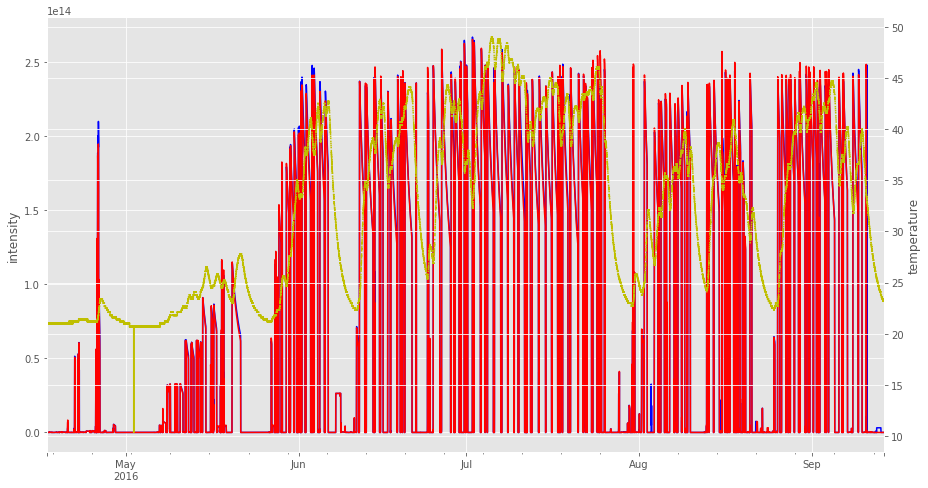

In [14]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
dfqr[dfqr.columns[0]].plot(ax=ax, style='b-')
dfqr[dfqr.columns[1]].plot(ax=ax, style='r-')
dfqr[dfqr.columns[2]].plot(ax=ax2, style='y')
ax.set_ylabel("intensity")
ax2.set_ylabel("temperature")
plt.show()

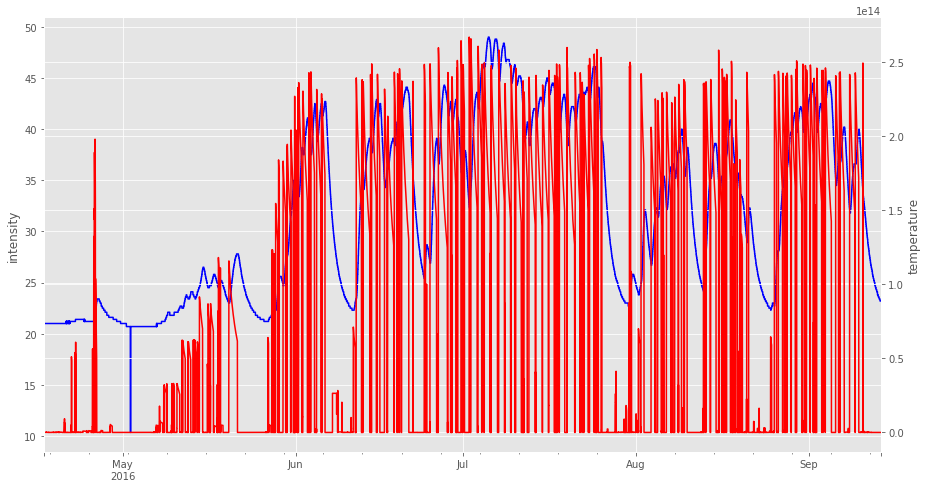

In [16]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
dfi[dfi.columns[0]].plot(ax=ax, style='b-')
dfi[dfi.columns[1]].plot(ax=ax2, style='r-')
ax.set_ylabel("intensity")
ax2.set_ylabel("temperature")

Plotting info for Pandas dataframes:
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

In case more than 2 axes: http://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes

<font color='red'>Plotting does *not* work because beam_intensity is sampled at different stamps!</font>


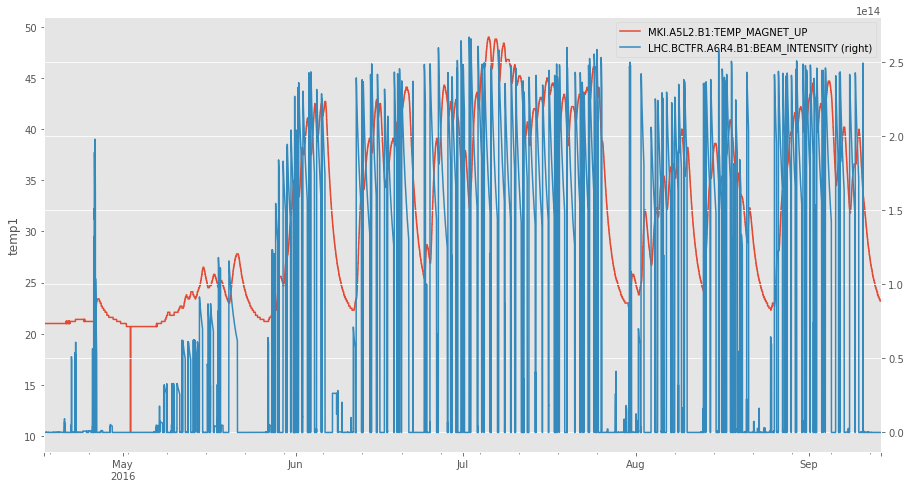

In [17]:
fig, ax = plt.subplots()
dfi.plot(ax=ax, secondary_y=dfi.columns[1])
ax.set_ylabel("temp1")

Fetching data for pattern MKI.A5L2.B1:TEMP_MAGNET_UP from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP


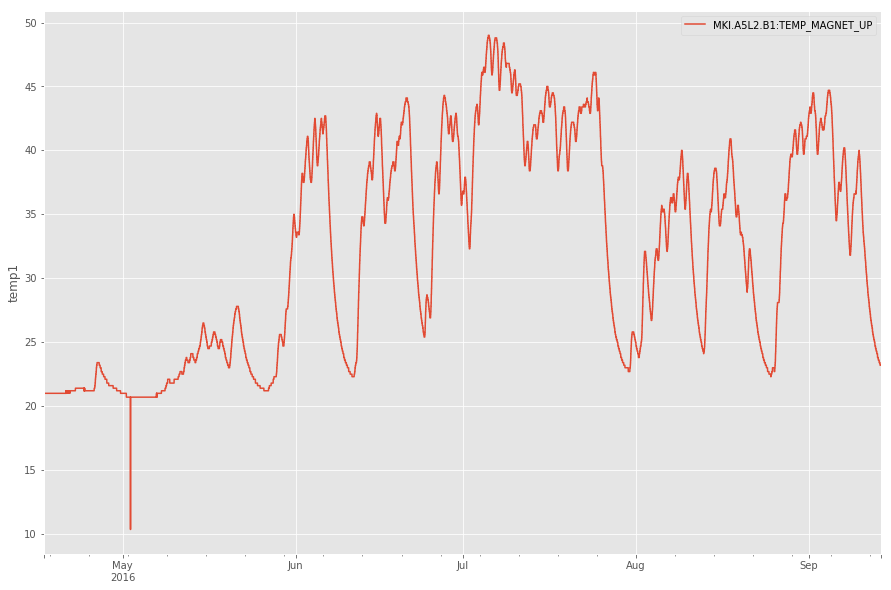

In [21]:
# plot only temperature, right under the other plot
dfi = dfi.drop(dfi.columns, axis=1)
dfi = pd.DataFrame()
dfi = dfi.rename_axis("timestamps")

ddic = db.query('MKI.A5L2.B1:TEMP_MAGNET_UP', resample_to="1min")
dfi = pd.concat([dfi, ddic], axis=1)

fig2, ax = plt.subplots(figsize=(15,10)) # figsize in inches
dfi.plot(ax=ax)
ax.set_ylabel("temp1")

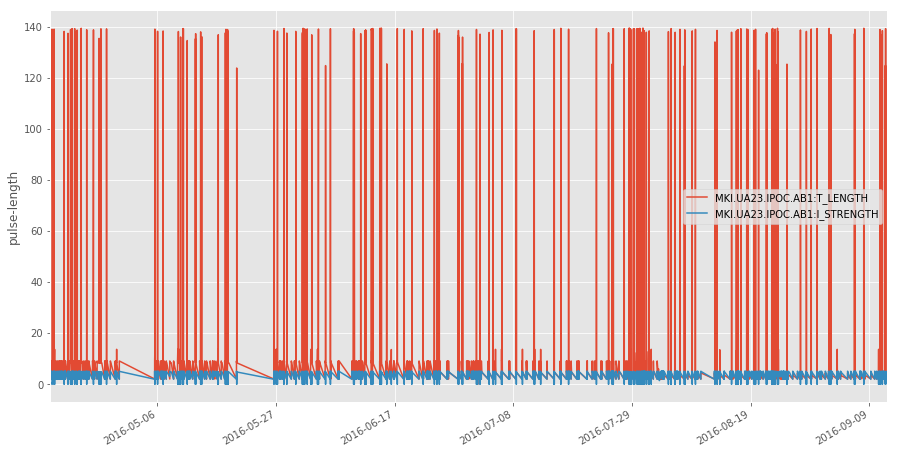

In [22]:
fig, axes = plt.subplots()
df.plot(ax=axes)
axes.set_ylabel("pulse-length")

Looks like I didn't provide enough data for the I_STRENGTH variables ...

# Filter based on I_STRENGTH>1kA

Some plotting info here: https://bespokeblog.wordpress.com/2011/07/07/basic-data-plotting-with-matplotlib-part-2-lines-points-formatting/

In [23]:
dff = df[(df['MKI.UA23.IPOC.AB1:I_STRENGTH']>1)]
dff.describe()

MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:I_STRENGTH
count                45742.000000                  45742.000000
mean                     3.494210                      4.647898
std                      2.242151                      0.662403
min                      2.059400                      1.450600
25%                      2.080300                      4.695425
50%                      2.085000                      4.833700
75%                      4.483700                      5.074800
max                      9.355800                      5.193200

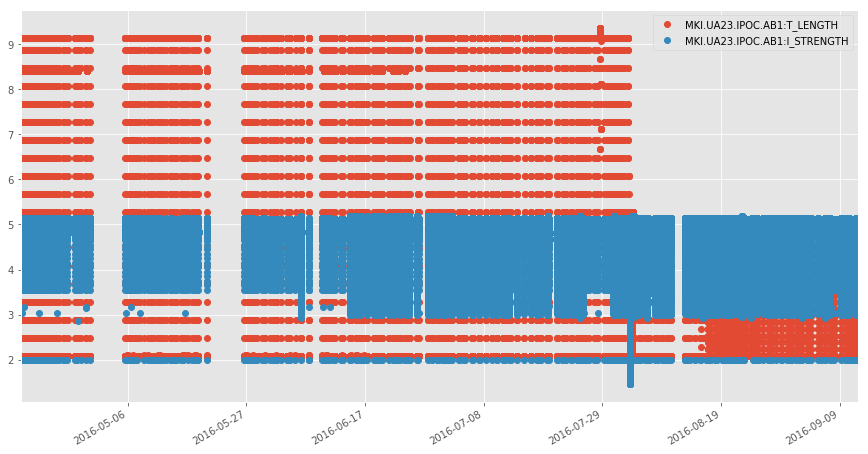

In [24]:
fig, axes = plt.subplots()
#dff.plot(kind='scatter', y=df.columns[0], x=df.index.values[0])
dff.plot(ax=axes, kind='line', marker='o', linestyle='none')